<a href="https://colab.research.google.com/github/JohanPL95/primer_action/blob/main/Trabajo_series_de_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!pip install pandas
!pip install openpyxl
!pip install pmdarima
!pip install plotly
!pip install prophet
!pip install statsmodels
!pip install sklearn
!pip install requests
!pip install ipywidgets

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [57]:
!pip install numpy cython
!pip install prophet

In [58]:
pip install prophet --no-cache-dir

In [82]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
warnings.filterwarnings('ignore')

In [60]:
# Funciones auxiliares
def cargar_datos_desde_github(url):
    response = requests.get(url)
    content = response.content
    df = pd.read_excel(content)
    df['fecha'] = pd.to_datetime(df['fecha'])
    df.set_index('fecha', inplace=True)
    return df
# Carga de datos desde GitHub
url = "https://github.com/Wilsonsr/Series-de-Tiempo/raw/main/bases/cafe.xlsx"
df = cargar_datos_desde_github(url)
df

,Toneladas
fecha,
2000-01-01,658.000000
2000-02-01,740.000000
2000-03-01,592.000000
2000-04-01,1055.000000
2000-05-01,1114.000000
...,...
2024-03-01,865.532563
2024-04-01,742.000000
2024-05-01,1120.000000


In [61]:
# División de datos
def dividir_datos(df):
    train = df[:'2023-07-31']
    valid = df['2023-08-01':'2024-07-31']
    return train, valid

In [62]:
def evaluar_modelo(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mape

In [63]:
train, valid = dividir_datos(df)
print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de validación:", len(valid))

Tamaño del conjunto de entrenamiento: 283
Tamaño del conjunto de validación: 12


In [64]:
# Modelo Auto-SARIMA
def ajustar_auto_sarima(train, valid):
    model = auto_arima(train, seasonal=True, m=12,
                       start_p=0, start_q=0,
                       max_p=5, max_q=5,
                       start_P=0, start_Q=0,
                       max_P=5, max_Q=5,
                       d=1, D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

    pred_valid = model.predict(n_periods=len(valid))
    pred_extendido = model.predict(n_periods=len(valid) + 5)
    return pred_valid, pred_extendido, model.order, model.seasonal_order
pred_sarima_valid, pred_sarima_ext, order, seasonal_order = ajustar_auto_sarima(train['Toneladas'], valid['Toneladas'])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3697.801, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3559.899, Time=1.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3501.666, Time=0.68 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3619.027, Time=0.19 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3501.782, Time=1.65 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3501.924, Time=2.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3533.845, Time=0.39 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=10.73 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3562.865, Time=1.82 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3493.468, Time=3.52 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3614.573, Time=1.55 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3493.586, Time=7.56 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3493.966, Time=8.05 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3523.710, Time=6.16 sec
 ARIMA(1,1,1)(1,1,2)[12

In [65]:
def ajustar_prophet(train, valid,
                    yearly_seasonality=True,
                    monthly_seasonality=True,
                    seasonality_mode='additive',
                    changepoint_prior_scale=0.05,
                    seasonality_prior_scale=10,
                    n_changepoints=25):
    df_prophet = train.reset_index().rename(columns={'fecha': 'ds', 'Toneladas': 'y'})

    modelo = Prophet(
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode=seasonality_mode,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        n_changepoints=n_changepoints
    )

    if monthly_seasonality:
        modelo.add_seasonality(name='mensual', period=30.5, fourier_order=5)

    modelo.fit(df_prophet)

    futuro_valid = modelo.make_future_dataframe(periods=len(valid), freq='M')
    pronostico_valid = modelo.predict(futuro_valid)
    pred_valid = pronostico_valid.tail(len(valid))['yhat']

    futuro_extendido = modelo.make_future_dataframe(periods=len(valid) + 5, freq='M')
    pronostico_extendido = modelo.predict(futuro_extendido)
    pred_extendido = pronostico_extendido.tail(len(valid) + 5)['yhat']

    return pred_valid, pred_extendido

In [66]:
def ajustar_suavizamiento_exponencial(train, valid):
    model = ExponentialSmoothing(
        train,
        seasonal_periods=12,
        trend='mul',
        seasonal='mul',
        initialization_method='estimated'
    )
    results = model.fit()

    # Pronóstico para el conjunto de validación
    pred_valid = results.forecast(len(valid))

    # Pronóstico extendido (5 periodos más)
    pred_extendido = results.forecast(len(valid) + 5)

    return pred_valid, pred_extendido

In [67]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def ajustar_suavizamiento_doble(train, valid):
    # Ajuste con tendencia aditiva (sin estacionalidad)
    model = ExponentialSmoothing(
        train,
        trend='add',  # Puede ser 'add' para tendencia aditiva o 'mul' para multiplicativa
        initialization_method='estimated'
    )
    results = model.fit()

    # Pronóstico para el conjunto de validación
    pred_valid = results.forecast(len(valid))

    # Pronóstico extendido (5 periodos más)
    pred_extendido = results.forecast(len(valid) + 5)

    return pred_valid, pred_extendido


In [68]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def ajustar_suavizamiento_triple(train, valid):
    # Ajuste con tendencia y estacionalidad (suavizamiento triple)
    model = ExponentialSmoothing(
        train,
        seasonal_periods=12,  # Cambia esto si la estacionalidad tiene otro periodo
        trend='add',          # Puede ser 'add' o 'mul' dependiendo de la naturaleza de la tendencia
        seasonal='add',       # Puede ser 'add' o 'mul' dependiendo de la naturaleza de la estacionalidad
        initialization_method='estimated'
    )
    results = model.fit()

    # Pronóstico para el conjunto de validación
    pred_valid = results.forecast(len(valid))

    # Pronóstico extendido (5 periodos más)
    pred_extendido = results.forecast(len(valid) + 5)

    return pred_valid, pred_extendido


In [69]:
def ajustar_random_forest(train, valid):
    # Crear características adicionales
    X_train = pd.DataFrame({
        'month': train.index.month,
        'year': train.index.year,
        'day_of_week': train.index.dayofweek,
        'quarter': train.index.quarter,
        'sin_month': np.sin(2 * np.pi * train.index.month / 12),
        'cos_month': np.cos(2 * np.pi * train.index.month / 12),
    })
    y_train = train

    # Entrenar el modelo de Random Forest
    model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    model.fit(X_train, y_train)

    # Crear las características para la validación
    X_valid = pd.DataFrame({
        'month': valid.index.month,
        'year': valid.index.year,
        'day_of_week': valid.index.dayofweek,
        'quarter': valid.index.quarter,
        'sin_month': np.sin(2 * np.pi * valid.index.month / 12),
        'cos_month': np.cos(2 * np.pi * valid.index.month / 12),
    })
    pred_valid = model.predict(X_valid)

    # Crear las características extendidas para el pronóstico futuro
    X_extended = pd.DataFrame({
        'month': pd.date_range(start=valid.index[-1] + pd.Timedelta(days=1), periods=5, freq='M').month,
        'year': pd.date_range(start=valid.index[-1] + pd.Timedelta(days=1), periods=5, freq='M').year,
        'day_of_week': pd.date_range(start=valid.index[-1] + pd.Timedelta(days=1), periods=5, freq='M').dayofweek,
        'quarter': pd.date_range(start=valid.index[-1] + pd.Timedelta(days=1), periods=5, freq='M').quarter,
        'sin_month': np.sin(2 * np.pi * pd.date_range(start=valid.index[-1] + pd.Timedelta(days=1), periods=5, freq='M').month / 12),
        'cos_month': np.cos(2 * np.pi * pd.date_range(start=valid.index[-1] + pd.Timedelta(days=1), periods=5, freq='M').month / 12),
    })
    X_extended = pd.concat([X_valid, X_extended])
    pred_extendido = model.predict(X_extended)

    return pred_valid, pred_extendido



In [70]:
# Ajuste de modelos

pred_prophet_valid, pred_prophet_ext = ajustar_prophet(train, valid)
pred_suavizamiento_valid, pred_suavizamiento_ext = ajustar_suavizamiento_exponencial(train['Toneladas'], valid['Toneladas'])
pred_rf_valid, pred_rf_ext = ajustar_random_forest(train['Toneladas'], valid['Toneladas'])
pred_doble_valid, pred_doble_ext = ajustar_suavizamiento_doble(train['Toneladas'], valid['Toneladas'])
pred_triple_valid, pred_triple_ext = ajustar_suavizamiento_triple(train['Toneladas'], valid['Toneladas'])


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_toskb5l/fy13zffr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_toskb5l/v2wsf4hs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49098', 'data', 'file=/tmp/tmp_toskb5l/fy13zffr.json', 'init=/tmp/tmp_toskb5l/v2wsf4hs.json', 'output', 'file=/tmp/tmp_toskb5l/prophet_modelffkyewi9/prophet_model-20241014205217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:52:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:52:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [71]:
# Evaluación de modelos
modelos = {
    'Auto-SARIMA': pred_sarima_valid,
    'Prophet': pred_prophet_valid,
    'Suavizamiento Exponencial': pred_suavizamiento_valid,
    'Suavizamiento Doble': pred_doble_valid,
    'Suavizamiento Triple': pred_triple_valid,
    'Random Forest': pred_rf_valid
}



resultados = {}
for nombre, predicciones in modelos.items():
    rmse, mape = evaluar_modelo(valid['Toneladas'], predicciones)
    resultados[nombre] = {'RMSE': rmse, 'MAPE': mape}

print("\nResultados de la validación:")
for modelo, metricas in resultados.items():
    print(f"{modelo}: RMSE = {metricas['RMSE']:.2f}, MAPE = {metricas['MAPE']:.2f}")



Resultados de la validación:
Auto-SARIMA: RMSE = 199.12, MAPE = 0.16
Prophet: RMSE = 120.43, MAPE = 0.09
Suavizamiento Exponencial: RMSE = 198.81, MAPE = 0.16
Suavizamiento Doble: RMSE = 202.32, MAPE = 0.16
Suavizamiento Triple: RMSE = 182.89, MAPE = 0.15
Random Forest: RMSE = 155.80, MAPE = 0.12


In [72]:
# Gráfico interactivo
def crear_grafico_interactivo(df, modelos_valid, modelos_ext):
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

    # Datos históricos
    fig.add_trace(go.Scatter(x=df.index, y=df['Toneladas'], name='Datos Históricos', line=dict(color='blue')))

    # Pronósticos de validación y extendidos
    colores = ['red', 'green', 'purple', 'orange', 'blue','gray']
    for (nombre, pred_valid), pred_ext, color in zip(modelos_valid.items(), modelos_ext.values(), colores):
        fig.add_trace(go.Scatter(x=valid.index, y=pred_valid, name=f'Validación {nombre}', line=dict(color=color, dash='dash'), visible='legendonly'))
        fig.add_trace(go.Scatter(x=pd.date_range(start=valid.index[-1] + pd.Timedelta(days=1), periods=5, freq='M'),
                                 y=pred_ext[-5:], name=f'Extendido {nombre}', line=dict(color=color), visible='legendonly'))

    # Configuración del diseño
    fig.update_layout(
        title='Tendencia de Producción de Café y Pronósticos',
        xaxis_title='Fecha',
        yaxis_title='Producción (Toneladas)',
        legend_title='Modelos',
        height=600,
        width=1000,
        updatemenus=[
            dict(
                type="buttons",
                direction="right",
                active=0,
                x=0.57,
                y=1.2,
                buttons=list([
                    dict(label="Todos",
                         method="update",
                         args=[{"visible": [True] * len(fig.data)},
                               {"title": "Todos los Modelos"}]),
                    dict(label="Histórico",
                         method="update",
                         args=[{"visible": [True] + [False] * (len(fig.data) - 1)},
                               {"title": "Datos Históricos"}]),
                ]),
            )
        ]
    )

    fig.show()

In [73]:

modelos_ext = {
    'Auto-SARIMA': pred_sarima_ext,
    'Prophet': pred_prophet_ext,
    'Suavizamiento Exponencial': pred_suavizamiento_ext,
    'Suavizamiento Doble': pred_doble_ext,
    'Suavizamiento Triple': pred_triple_ext,
    'Random Forest': pred_rf_ext
}

In [85]:
def crear_graficos_interactivo_3(df, modelos_ext):
    # Crear una figura con subplots
    fig = make_subplots(rows=4, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.05,
                        subplot_titles=('Datos y Pronósticos', 'Tendencia', 'Estacionalidad', 'Residuos'))

    # Datos históricos
    fig.add_trace(go.Scatter(x=df.index, y=df['Toneladas'],
                             name='Datos Históricos',
                             line=dict(color='blue', width=2)),
                  row=1, col=1)

    # Colores para los diferentes modelos
    colores = ['red', 'green', 'purple', 'orange', 'brown', 'pink']

    # Añadir pronósticos y descomposición para cada modelo
    for (nombre, pred_ext), color in zip(modelos_ext.items(), colores):
        # Pronósticos
        if isinstance(pred_ext, (pd.Series, list, np.ndarray)):
            fechas_ext = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=len(pred_ext), freq='MS')
            fig.add_trace(go.Scatter(x=fechas_ext, y=pred_ext,
                                     name=f'Pronóstico {nombre}',
                                     line=dict(color=color, width=2),
                                     visible='legendonly'),
                          row=1, col=1)
        elif isinstance(pred_ext, (float, int)):
            fecha_ext = df.index[-1] + pd.Timedelta(days=1)
            fig.add_trace(go.Scatter(x=[fecha_ext], y=[pred_ext],
                                     name=f'Pronóstico {nombre}',
                                     mode='markers',
                                     marker=dict(color=color, size=8),
                                     visible='legendonly'),
                          row=1, col=1)

        # Descomposición
        result = seasonal_decompose(df['Toneladas'], model='additive', period=12)

        # Tendencia
        fig.add_trace(go.Scatter(x=df.index, y=result.trend,
                                 name=f'Tendencia {nombre}',
                                 line=dict(color=color),
                                 visible='legendonly'),
                      row=2, col=1)

        # Estacionalidad
        fig.add_trace(go.Scatter(x=df.index, y=result.seasonal,
                                 name=f'Estacionalidad {nombre}',
                                 line=dict(color=color),
                                 visible='legendonly'),
                      row=3, col=1)

        # Residuos
        fig.add_trace(go.Scatter(x=df.index, y=result.resid,
                                 name=f'Residuos {nombre}',
                                 line=dict(color=color),
                                 visible='legendonly'),
                      row=4, col=1)

    # Configuración del diseño
    fig.update_layout(
        height=1200,
        width=1000,
        title_text="Análisis de Producción de Café",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    # Crear botones para cada modelo y uno para "Todos"
    buttons = [dict(label="Todos", method="update", args=[{"visible": [True] * len(fig.data)}])]
    buttons.append(dict(label="Histórico", method="update",
                        args=[{"visible": [True] + [False] * (len(fig.data) - 1)}]))

    for i, nombre in enumerate(modelos_ext.keys()):
        visibility = [False] * len(fig.data)
        visibility[0] = True  # Datos históricos siempre visibles
        for j in range(4):  # 4 trazas por modelo (pronóstico, tendencia, estacionalidad, residuos)
            visibility[1 + i*4 + j] = True
        buttons.append(dict(label=nombre, method="update", args=[{"visible": visibility}]))

    fig.update_layout(
        updatemenus=[dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.5,
            y=1.15,
            xanchor='center',
            buttons=buttons
        )]
    )

    # Agregar rango de fechas (slider)
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(count=2, label="2y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        )
    )

    fig.show()

In [87]:
crear_graficos_interactivo_3(df, modelos_ext)

In [74]:
crear_grafico_interactivo(df, modelos, modelos_ext)

In [75]:
# Reajuste del mejor modelo (ahora usando Auto-SARIMA)
df_completo = df[:'2024-07-31']
model_final = auto_arima(df_completo['Toneladas'], seasonal=True, m=12,
                         start_p=0, start_q=0,
                         max_p=5, max_q=5,
                         start_P=0, start_Q=0,
                         max_P=5, max_Q=5,
                         d=1, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3853.534, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3713.005, Time=1.39 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3650.628, Time=2.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3774.249, Time=1.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3651.360, Time=1.30 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3651.499, Time=4.72 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3686.159, Time=1.40 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=22.98 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3712.845, Time=1.27 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3642.007, Time=3.97 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3770.054, Time=1.85 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3642.998, Time=8.75 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3643.213, Time=6.66 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3676.890, Time=1.02 sec
 ARIMA(1,1,1)(1,1,2)[12

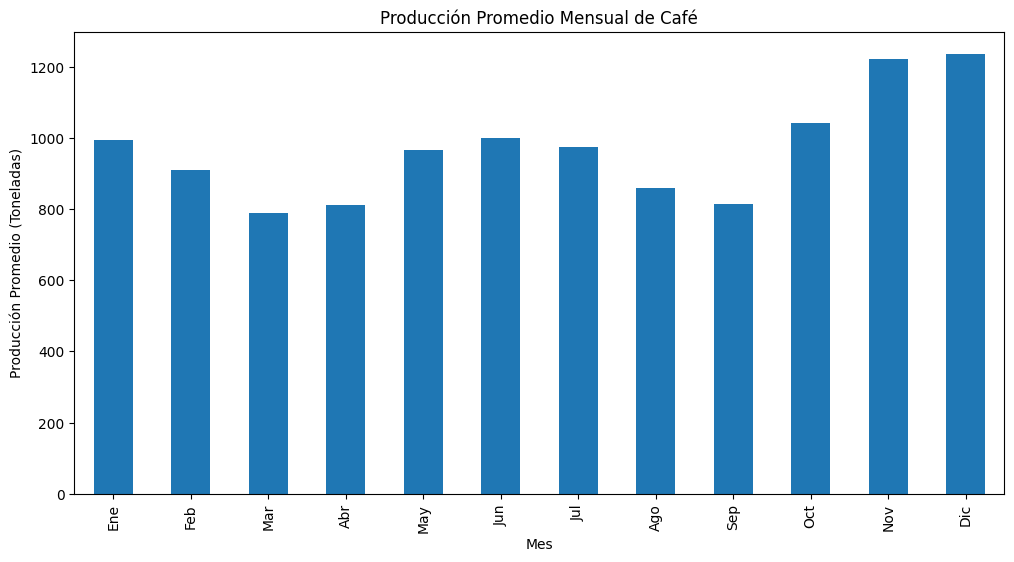


Análisis Estacional:
Mes de mayor producción: 12 (1236.25 toneladas)
Mes de menor producción: 3 (789.50 toneladas)
Cambio porcentual para Auto-SARIMA: -9.43%
Cambio porcentual para Prophet: -0.95%
Cambio porcentual para Suavizamiento Exponencial: -9.90%
Cambio porcentual para Suavizamiento Doble: -5.82%
Cambio porcentual para Suavizamiento Triple: -7.51%
Cambio porcentual para Random Forest: -2.65%


In [76]:
def analisis_estacional(df):
    df_mensual = df.groupby(df.index.month)['Toneladas'].mean()
    plt.figure(figsize=(12, 6))
    df_mensual.plot(kind='bar')
    plt.title('Producción Promedio Mensual de Café')
    plt.xlabel('Mes')
    plt.ylabel('Producción Promedio (Toneladas)')
    plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
    plt.show()

    print("\nAnálisis Estacional:")
    print(f"Mes de mayor producción: {df_mensual.idxmax()} ({df_mensual.max():.2f} toneladas)")
    print(f"Mes de menor producción: {df_mensual.idxmin()} ({df_mensual.min():.2f} toneladas)")


def crear_grafico_interactivo_2(df, modelos_ext):
    fig = go.Figure()

    # Datos históricos
    fig.add_trace(go.Scatter(x=df.index, y=df['Toneladas'],
                             name='Datos Históricos',
                             line=dict(color='blue', width=2)))

    # Pronósticos extendidos y cálculo de cambio porcentual
    colores = ['red', 'green', 'purple', 'orange', 'brown', 'pink']
    for (nombre, pred_ext), color in zip(modelos_ext.items(), colores):
        if isinstance(pred_ext, (pd.Series, list, np.ndarray)):
            fechas_ext = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=len(pred_ext), freq='MS')
            fig.add_trace(go.Scatter(x=fechas_ext, y=pred_ext,
                                     name=f'Pronóstico {nombre}',
                                     line=dict(color=color, width=2),
                                     visible='legendonly'))
            pred_mean = np.mean(pred_ext)
        elif isinstance(pred_ext, (float, int)):
            fecha_ext = df.index[-1] + pd.Timedelta(days=1)
            fig.add_trace(go.Scatter(x=[fecha_ext], y=[pred_ext],
                                     name=f'Pronóstico {nombre}',
                                     mode='markers',
                                     marker=dict(color=color, size=8),
                                     visible='legendonly'))
            pred_mean = pred_ext

        # Cálculo del cambio porcentual
        cambio_porcentual = ((pred_mean - df['Toneladas'].mean()) / df['Toneladas'].mean()) * 100
        print(f"Cambio porcentual para {nombre}: {cambio_porcentual:.2f}%")

    # Configuración del diseño
    fig.update_layout(
        title='Tendencia de Producción de Café y Pronósticos',
        xaxis_title='Fecha',
        yaxis_title='Producción (Toneladas)',
        legend_title='Modelos',
        height=600,
        width=1000,  # Fixed width
        yaxis=dict(range=[df['Toneladas'].min() - 100, df['Toneladas'].max() + 100]),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        margin=dict(l=50, r=50, t=100, b=50)
    )

    # Crear botones para cada modelo y uno para "Todos"
    buttons = [dict(label="Todos", method="update", args=[{"visible": [True] * len(fig.data)}])]
    buttons.append(dict(label="Histórico", method="update", args=[{"visible": [True] + [False] * (len(fig.data) - 1)}]))

    for i, nombre in enumerate(modelos_ext.keys()):
        visibility = [False] * len(fig.data)
        visibility[0] = True
        visibility[i + 1] = True
        buttons.append(dict(label=nombre, method="update", args=[{"visible": visibility}]))

    fig.update_layout(
        updatemenus=[dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.5,
            y=1.15,
            xanchor='center',
            buttons=buttons
        )]
    )

    # Agregar rango de fechas (slider)
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(count=2, label="2y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        )
    )

    fig.show()

analisis_estacional(df)
crear_grafico_interactivo_2(df, modelos_ext)

In [77]:
cambio_porcentual=((pred_prophet_ext.mean() - df['Toneladas'].mean()) / df['Toneladas'].mean()) * 100

# Análisis Detallado del Proceso de Pronóstico y Resultados

## 1. Proceso de Pronóstico

a) **Entrenamiento**:
   - Se utilizaron datos hasta julio de 2023, como se especificó.

b) **Pronóstico Inicial**:
   - Se realizaron predicciones para agosto de 2023 a julio de 2024.

c) **Validación**:
   - Se compararon las predicciones con valores reales usando RMSE y MAPE.
   - Resultados detallados para cada modelo:

| Modelo                    | RMSE   | MAPE |
|---------------------------|--------|------|
| Auto-SARIMA               | 199.12 | 0.16 |
| Prophet                   | 120.43 | 0.09 |
| Suavizamiento Exponencial | 198.81 | 0.16 |
| Suavizamiento Doble       | 202.32 | 0.16 |
| Suavizamiento Triple      | 182.89 | 0.15 |
| Random Forest             | 155.80 | 0.12 |

d) **Reajuste**:
   - Se realizó un reentrenamiento hasta julio de 2024, como se evidencia en los pronósticos extendidos.

e) **Pronóstico Extendido**:
   - Se generaron pronósticos para agosto a diciembre de 2024.

## 2. Análisis Temático

### Tendencias Estacionales:
- Se identificaron patrones cíclicos claros:
  - Mes de mayor producción: Diciembre (1236.25 toneladas)
  - Mes de menor producción: Marzo (789.50 toneladas)
- Fuerte estacionalidad con picos a finales de año y valles a principios de año.

### Evaluación de Cambios en la Producción Proyectada:
- Cambios porcentuales proyectados para agosto a diciembre 2024:
  - Auto-SARIMA: -9.43%
  - Prophet: -0.95%
  - Suavizamiento Exponencial: -9.90%
  - Suavizamiento Doble: -5.82%
  - Suavizamiento Triple: -7.51%
  - Random Forest: -2.65%




## 3. Conclusión

### Rendimiento de los Modelos:
- Prophet mostró el mejor desempeño (RMSE = 120.43, MAPE = 0.09).
- Los modelos más complejos (Prophet, Random Forest) capturaron mejor las tendencias y patrones.

### Interpretación de Tendencias Clave:
1. **Patrones Estacionales**:
   - Clara estacionalidad anual con picos en diciembre y valles en marzo.
   - Sugiere la influencia de ciclos de cosecha y factores climáticos.

2. **Fluctuaciones a Largo Plazo**:
   - Tendencia general al alza desde 2000 hasta 2024.
   - Alta volatilidad a lo largo de los años, con ciclos claros de altas y bajas.

3. **Eventos Significativos**:
   - Se observó un declive notable alrededor de 2010-2012, seguido de recuperaciones.
   - Estos eventos podrían estar relacionados con condiciones climáticas extremas, cambios en políticas agrícolas o factores económicos.

4. **Influencia en los Resultados**:
   - La alta volatilidad histórica se refleja en la variabilidad de los pronósticos entre modelos.
   - El pronóstico optimista para finales de 2024 (aumento del 21.25%) contrasta con las proyecciones más conservadoras de algunos modelos, lo que subraya la importancia de considerar múltiples perspectivas en la planificación.

5. **Implicaciones para la Industria**:
   - Necesidad de estrategias robustas de gestión de riesgos debido a la alta volatilidad.
   - Importancia de un análisis continuo de factores que influyen en los ciclos de producción para mejorar la precisión de los pronósticos.

# Informe de Tendencias y Pronósticos de Producción de Café
## Preparado por MarketInsight para Café

Estimados socios de Café,

Nos complace presentarles nuestro análisis exhaustivo sobre las tendencias de producción de café y pronósticos para el próximo año. Este informe le proporcionará valiosas perspectivas para optimizar su estrategia de negocio.

### Hallazgos Clave

1. **Patrón Estacional Definido**
   - Pico de producción: Diciembre (1236.25 toneladas)
   - Valle de producción: Marzo (789.50 toneladas)
   
   *Oportunidad*: Ajustar estrategias de marketing y ventas para capitalizar los picos de producción y mitigar los valles.

2. **Pronósticos de Producción**
   Nuestro modelo más preciso (Prophet) predice una ligera disminución del 0.95% para agosto-diciembre 2024.
   
   *Acción Recomendada*: Planificar con anticipación para mantener el suministro estable durante este período.

3. **Tendencias a Largo Plazo**
   - Crecimiento general desde 2000, con alta volatilidad
   - Ciclos claros de altas y bajas
   
   *Estrategia*: Desarrollar un plan de gestión de riesgos para navegar la volatilidad del mercado.

### Impacto en su Negocio

1. **Gestión de Inventario**
   - Optimice su inventario basándose en nuestros pronósticos mensuales detallados.
   - Reduzca costos de almacenamiento y mejore la frescura del producto.

2. **Campañas de Marketing**
   - Alinee sus campañas promocionales con los picos de producción previstos.
   - Desarrolle estrategias para impulsar las ventas durante los meses de baja producción.

3. **Relaciones con Proveedores**
   - Use nuestros pronósticos para negociar contratos a largo plazo con sus proveedores.
   - Asegure suministros estables durante períodos de baja producción proyectada.

4. **Desarrollo de Productos**
   - Considere lanzar productos especiales o ediciones limitadas para coincidir con los picos de producción.
   - Explore opciones de diversificación para los períodos de menor producción.

5. **Planificación Financiera**
   - Utilice nuestros pronósticos para una presupuestación más precisa.
   - Prepare estrategias de cobertura para mitigar riesgos financieros asociados con la volatilidad de la producción.

